<a href="https://colab.research.google.com/github/rohitamar/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

        self.mu = nn.Linear(256, latent_dim)
        self.logvar = nn.Linear(256, latent_dim)

    def reparam(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.mu(x), self.logvar(x)
        z = self.reparam(mu, logvar)
        x_r = self.decode(z)
        return x_r, mu, logvar

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
from torch.optim import Adam

def train_model(model, dataloader, config):
    epochs = config['epochs']
    optimizer = Adam(model.parameters(), lr=1e-3)

    avg_losses = []
    avg_recons = []
    avg_kls = []

    model = model.cuda()
    for epoch in range(epochs):
        avg_loss = avg_recon = avg_kl = 0.0
        samples = 0
        for step, data in enumerate(dataloader):
            input, _ = data
            input = input.cuda()
            input = input.reshape(-1, 28 * 28)
            batch_size = input.size(0)

            preds, mu, logvar = model(input)

            recon = F.binary_cross_entropy(preds, input, reduction='sum')
            kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = (recon + kl) / batch_size

            avg_loss += loss.item() * batch_size
            avg_recon += recon.item()
            avg_kl += kl.item()
            samples += batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss /= samples
        avg_recon /= samples
        avg_kl /= samples

        print(f"Epoch {epoch} - Recon: {avg_recon} KL: {avg_kl} Both: {avg_loss}")
        avg_losses.append(avg_loss)
        avg_recons.append(avg_recon)
        avg_kls.append(avg_kl)

    return avg_losses, avg_recons, avg_kls

In [ ]:
model = VAE(20)

loss, recon, kl = train_model(model, train_loader, {
    'epochs': 50
})

Epoch 0 - Recon: 122.98747788899739 KL: 18.976109251999855 Both: 141.96358728027343
Epoch 1 - Recon: 91.85184677734375 KL: 23.729539756266277 Both: 115.58138649495443
Epoch 2 - Recon: 87.22744310709635 KL: 24.492434791056315 Both: 111.71987801513671
Epoch 3 - Recon: 85.17947650146485 KL: 24.750166208902996 Both: 109.92964269612631
Epoch 4 - Recon: 84.00589678548177 KL: 24.901588959757486 Both: 108.90748577067058
Epoch 5 - Recon: 83.18187395019531 KL: 24.962899103800456 Both: 108.14477303466796
Epoch 6 - Recon: 82.62945161132812 KL: 25.030939235432943 Both: 107.66039094645183
Epoch 7 - Recon: 82.14420399983725 KL: 25.0848662109375 Both: 107.22907025960286
Epoch 8 - Recon: 81.77586929931641 KL: 25.118287066650392 Both: 106.89415642089844
Epoch 9 - Recon: 81.47235349527995 KL: 25.121214330037436 Both: 106.59356786295572
Epoch 10 - Recon: 81.16939312744141 KL: 25.14683571879069 Both: 106.31622895100911
Epoch 11 - Recon: 80.95528394775391 KL: 25.170229114786785 Both: 106.12551303710937
Epoc

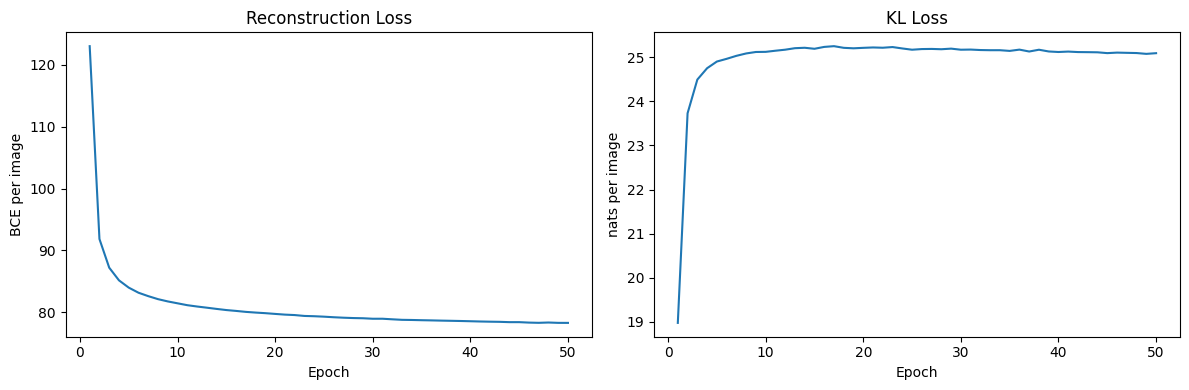

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))   # 1 row, 2 columns

axes[0].plot(range(1, len(recon) + 1), recon)
axes[0].set_title("Reconstruction Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("BCE per image")

axes[1].plot(range(1, len(kl) + 1), kl)
axes[1].set_title("KL Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("nats per image")

plt.tight_layout()
plt.show()

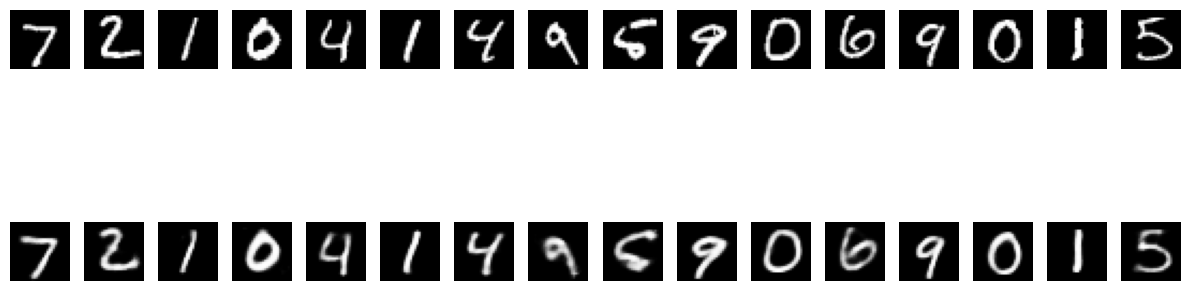

In [ ]:
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.cuda().view(-1, 28 * 28)
    recon, _, _ = model(x)

plt.figure(figsize=(12,6))
for i in range(16):
    plt.subplot(2, 16, i + 1)
    plt.imshow(x[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 16, i + 17)
    plt.imshow(recon[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

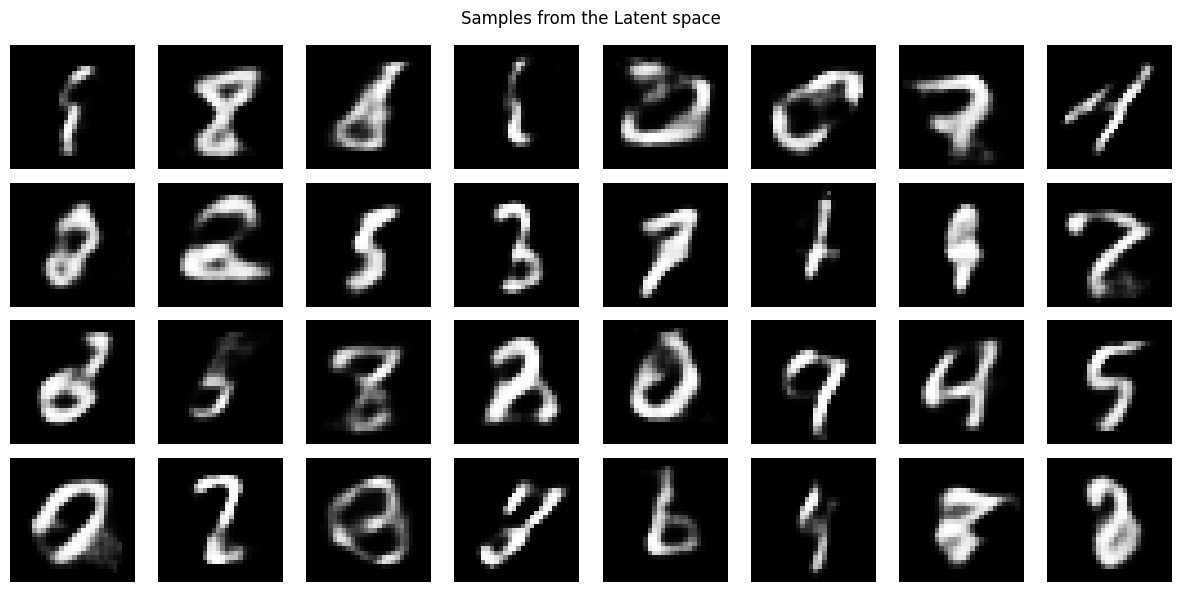

In [ ]:
z = torch.randn(32, 20, device=device)
with torch.no_grad():
    samples = model.decoder(z)

plt.figure(figsize=(12, 6))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].cpu().view(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Samples from the Latent space")
plt.tight_layout()
plt.show()